## Descriptive statistics

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'fcor_boost' : 1,         
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':     '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/',
    'save_csv_path': '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/csv_files/',
}

In [4]:
# ### OPEN
ds_ibt = xr.open_dataset(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')
# ds_ibt

In [5]:
ds = ds_ibt.isel(storm=-6)
ds['name']

<xarray.DataArray 'name' ()>
array(b'LARRY', dtype='|S128')
Attributes:
    long_name:              Name of system
    description:            May be a combination of names from different agen...
    coverage_content_type:  thematicClassification

In [6]:
ds['time'][0]

<xarray.DataArray 'time' ()>
array('2021-08-30T00:00:00.000039936', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] ...
    lat      float32 ...
    lon      float32 ...
Attributes:
    long_name:              time
    standard_name:          time
    description:            Nominally, time steps are 3 hourly, but can be mo...
    Note:                   Variable:time can be missing since the tracks are...
    coverage_content_type:  physicalMeasurement

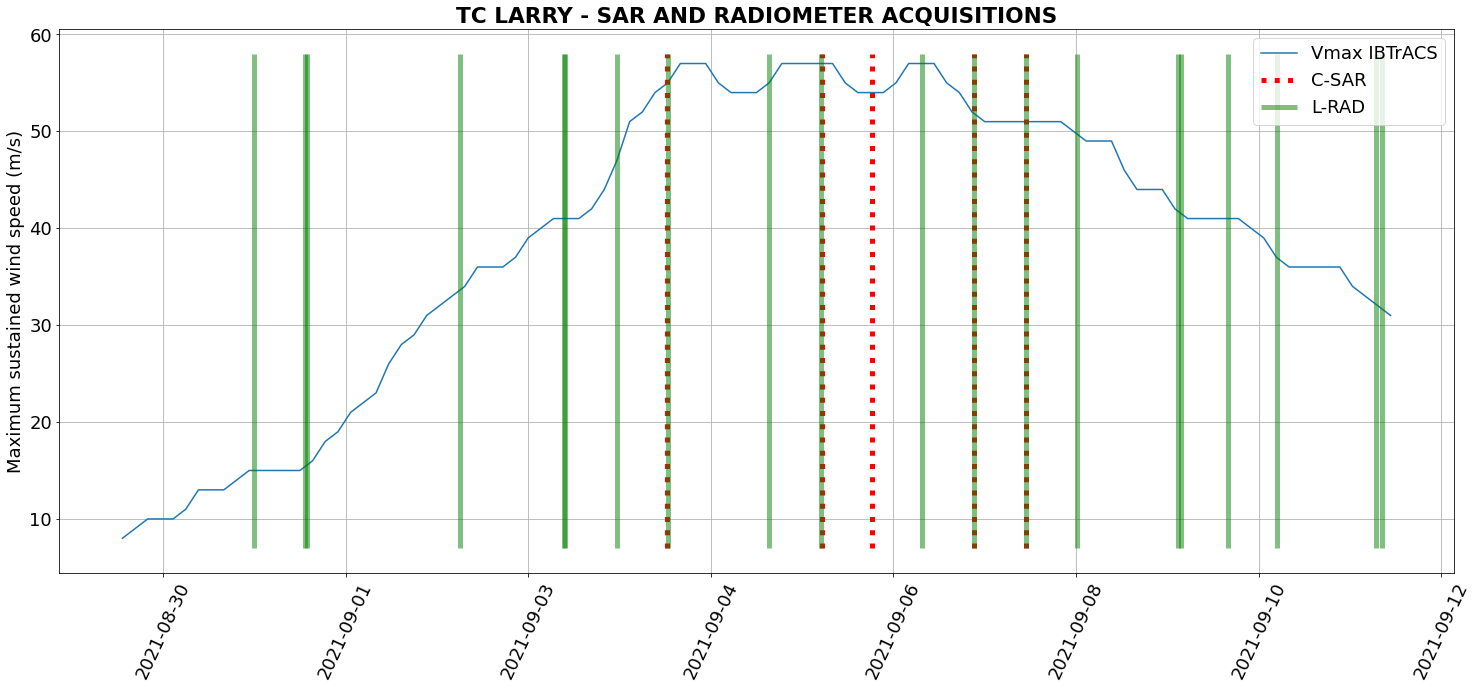

In [9]:
# LARRY EXAMPLE: SAR and RAD acquisitions
import matplotlib.ticker as ticker

SAR_times = [
    np.datetime64('2021-09-04T08:51'),
    np.datetime64('2021-09-05T21:33'),
    np.datetime64('2021-09-06T09:23'),
    np.datetime64('2021-09-07T09:28'),
    np.datetime64('2021-09-07T21:46'),
]
# SAR_vmaxs = [ # TC analysis of Cyclobs by quadrants, then highest of the 4 vmaxs was selected
#     43.21,
#     37.04,
#     51.4,
#     37.5,
#     42.7,    
# ]
RAD_times = [
    np.datetime64('2021-08-31T07:13'),
    np.datetime64('2021-08-31T19:08'),
    np.datetime64('2021-08-31T19:37'),
    np.datetime64('2021-09-02T07:57'),
    np.datetime64('2021-09-03T08:33'),
    np.datetime64('2021-09-03T08:37'),
    np.datetime64('2021-09-03T20:58'),
    np.datetime64('2021-09-04T09:10'),
    np.datetime64('2021-09-05T09:00'),
    
    np.datetime64('2021-09-05T21:19'),
    np.datetime64('2021-09-06T21:14'),
    np.datetime64('2021-09-07T09:25'),
    np.datetime64('2021-09-07T21:40'),
    np.datetime64('2021-09-08T09:56'),
    
    np.datetime64('2021-09-09T09:49'),
    np.datetime64('2021-09-09T10:32'),
    np.datetime64('2021-09-09T21:30'),
    np.datetime64('2021-09-10T09:11'),
    np.datetime64('2021-09-11T08:36'),
    np.datetime64('2021-09-11T10:01'),
]

fig, ax = plt.subplots(figsize=(25, 10))
plt.title('TC LARRY - SAR AND RADIOMETER ACQUISITIONS', weight='bold')
plt.plot(ds['time'], ds['usa_wind'], label='Vmax IBTrACS');plt.grid()
# plt.scatter(SAR_times, SAR_vmaxs, label='SAR', c='r', marker=(5, 1), s=80)
plt.vlines(SAR_times, ymin=7, ymax=58, colors='r', lw=5, ls=':', label='C-SAR')
plt.vlines(RAD_times, ymin=7, ymax=58, colors='g', lw=5, alpha=0.5, label='L-RAD')

plt.legend()
plt.ylabel('Maximum sustained wind speed (m/s)')
plt.xticks(rotation=65)  
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.8))